# Three Dimensions of Scientific Impact

by Grzegorz Siudem, Barbara Żogała-Siudem, Anna Cena and Marek Gagolewski

April 2020


Code by M.Gagolewski, Copyright (C) 2018-2020

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

## Auxiliary Functions, Initial Setup

In [1]:
%load_ext Cython
%matplotlib inline
%config InlineBackend.figure_format = 'png'
#----%config InlineBackend.figure_formats=['svg']

In [2]:
import numpy as np, matplotlib.pyplot as plt, matplotlib, matplotlib.image
from IPython.display import display, Markdown, Latex
import pandas as pd, seaborn as sns
import scipy.optimize, scipy.special
import pandas as pd

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Helvetica Neue', 'Helvetica Neue LT']+plt.rcParams['font.sans-serif']
pd.set_option('max_colwidth', 120)
plt.style.use('seaborn-whitegrid')

In [3]:
def hirsch(x):
    return np.max(np.minimum(x, np.arange(1, len(x)+1)))

q1 = lambda x: np.percentile(x, 25)
q1.__name__="Q1"

q3 = lambda x: np.percentile(x, 75)
q3.__name__="Q3"

def scatter(x, y, log_x=False, log_y=False, xlim=None, ylim=None,
            fig=None, ax=None, *args, **kwargs):
    if ax is None:
        if fig is None:
            fig = plt.figure()
        ax = fig.add_subplot(111)

    ax.scatter(x, y, *args, **kwargs)
    if log_x: ax.set_xscale("log")#, nonposx='clip')
    if log_y: ax.set_yscale("log")#, nonposy='clip')
    if xlim is not None: plt.xlim(*xlim)
    if ylim is not None: plt.ylim(*ylim)

    return ax


def log_bin_averaged(x, num, normalize=False):
    # num is maxnum

    x_log_bins = np.unique(np.ceil(np.geomspace(1, x.shape[0]+1, num)))
    _dgtz = np.digitize(np.arange(1, x.shape[0]+1), x_log_bins)-1
    _cntz = np.bincount(_dgtz)
    _smz  = np.zeros(_cntz.shape[0])
    for i in range(x.shape[0]): _smz[_dgtz[i]] += x[i]
    assert np.abs(_smz.sum() - x.sum())<1e-9
    for i in range(_smz.shape[0]): _smz[i] /= _cntz[i] if _cntz[i]>0.0 else 0.0
    if normalize:
        x_log_counts = _smz/_smz.sum()
    else:
        x_log_counts = _smz
    x_log_bins = (x_log_bins[:-1]+x_log_bins[1:])*0.5
    x_log_bins   = x_log_bins[x_log_counts>0]
    x_log_counts = x_log_counts[x_log_counts>0]
    return x_log_bins, x_log_counts

## Load Data

We study the DBLP-Citation-Network V10 data set of computer science papers, see https://aminer.org/citation.
    
We have extracted the citation sequences of all the authors, see the `citation_sequences_aminer_dblp_v10.json.gz` file.
    

In [4]:
import json, gzip
with gzip.open("citation_sequences_aminer_dblp_v10.json.gz", "rb") as f:
    X = json.loads(f.read().decode("ascii"))
# Convert the dictionary of citation sequences to a list
X_id = list(X.keys())
X = [ np.array(X[key]) for key in X_id ]
for x in X: assert np.all(np.diff(x) <= 0) # check is sorted nonincreasingly

We will only consider citation records of the scholars whose $h$-index is at least 5. 

In [5]:
# Compute the h-index of each author:
X_H = np.array([hirsch(x) for x in X])
authors_subset = (X_H>=5)

In [6]:
# Compute the number of papers (N), citations (C) and the h-index (H)
X2 = [X[i] for i in range(len(X)) if authors_subset[i] ]
X2_id = [X_id[i] for i in range(len(X)) if authors_subset[i] ]
X2 = [_x[_x>0] for _x in X2 ] # omit papers with 0 citations
X2_N = np.array([x.shape[0] for x in X2])
X2_C = np.array([x.sum() for x in X2])
X2_H = np.array([hirsch(x) for x in X2])
len(X2) # How many authors in the sample?

123621

## The Model (Eq. [14])

In [7]:
# X_k(N,C,rho) -- see eq. [14] in the paper (k=x, rho=param[0])
model3 = lambda param, x, C, N: (1.0-param[0])*C*(scipy.special.poch(x,-param[0])/scipy.special.poch(N+1,-param[0]) - 1.0)/N/param[0]

In [8]:
# log X_k(N,C,rho):
model3_log = lambda param, x, C, N: \
    np.log((1.0-param[0])*C)+np.log(scipy.special.poch(x,-param[0])/scipy.special.poch(N+1,-param[0]) - 1.0)-np.log(N*param[0])

## Fit $\varrho$

In [9]:
def fit_model(x, y, model_log, param0, bounds, args=[], loss='cauchy'):
    def resid(param, x, y, args):
        return model_log(param, x, *args)-np.log(y)
    
    return scipy.optimize.least_squares(resid, param0, kwargs={"x": x, "y": y, "args": args},
           bounds=bounds, loss=loss)

In [10]:
# Estimate the rho parameter of each citation sequence
X2_rho = np.empty(len(X2)) # to be determined below
for i in range(len(X2)):
    _x = X2[i]
    try:   
        res = fit_model(np.arange(1, len(_x)+1), _x, model3_log, [0.5], args=[_x.sum(), _x.shape[0]],
                bounds=([1e-6], [1-1e-6]), loss='cauchy')
        assert res["success"]
        X2_rho[i] = res["x"]
        
    except:
        print("*")
        
    if i%10000==0: print("%3.0f%% done"%(100*i/len(X2))) # a "progress bar"
                         
print("All  done.")

  0% done
  8% done
 16% done
 24% done
 32% done
 40% done
 49% done
 57% done
 65% done
 73% done
 81% done
 89% done
 97% done
All  done.


## Export Data

In [11]:
X2_res = pd.DataFrame({"id": X2_id, "N": X2_N, "C": X2_C, "rho": X2_rho, "H": X2_H})
X2_res.to_csv("estimated_parameters_aminer_dblp_v10.csv.gz", compression="gzip", index=False)
X2_res.head()

,id,N,C,rho,H
0,Wei Wang,1550,17910,0.588720,57
1,Wei Zhang,1013,11012,0.532614,42
2,Lei Zhang,1059,19739,0.615029,66
3,Yang Liu,972,8631,0.391784,37
4,Wei Li,848,9087,0.555201,40


## Figure 3: Distribution of $\varrho$ as a Function of $N$ and $C$

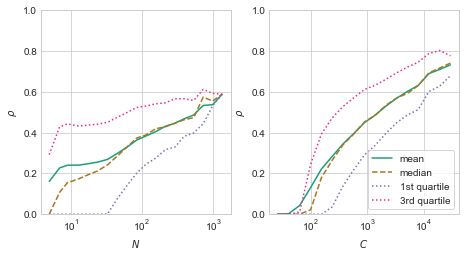

In [12]:
plt.rcParams["figure.figsize"] = (3.75*2, 3.75)
cols = plt.get_cmap("Dark2").colors

plt.subplot(121)
cuts = np.unique(np.floor(np.geomspace(1, X2_N.max()+1, 25)))
Ncut = pd.cut(X2_N, cuts, labels=0.5*(cuts[1:]+cuts[:-1])).astype("int")
res = pd.DataFrame({"N":Ncut, "alpha":X2_rho}).groupby("N").agg([np.mean, np.median, q1, q3])
plt.plot(res.index, res.iloc[:,0], label="mean", linestyle="-", c=cols[0])
plt.plot(res.index, res.iloc[:,1], label="median", linestyle="--", c=cols[6])
plt.plot(res.index, res.iloc[:,2], label="1st quartile", linestyle=":", c=cols[2])
plt.plot(res.index, res.iloc[:,3], label="3rd quartile", linestyle=":", c=cols[3])
plt.xscale("log")
plt.ylim(0,1)
plt.xlabel(r"$N$")
plt.ylabel(r"$\rho$")

plt.subplot(122)
cuts = np.unique(np.floor(np.geomspace(1, X2_C.max()+1, 25)))
Ccut = pd.cut(X2_C, cuts, labels=0.5*(cuts[1:]+cuts[:-1])).astype("int")
res = pd.DataFrame({"C":Ccut, "alpha":X2_rho}).groupby("C").agg([np.mean, np.median, q1, q3])
plt.plot(res.index, res.iloc[:,0], label="mean", linestyle="-", c=cols[0])
plt.plot(res.index, res.iloc[:,1], label="median", linestyle="--", c=cols[6])
plt.plot(res.index, res.iloc[:,2], label="1st quartile", linestyle=":", c=cols[2])
plt.plot(res.index, res.iloc[:,3], label="3rd quartile", linestyle=":", c=cols[3])
plt.xscale("log")
plt.legend(loc="lower right", frameon=True)
plt.ylim(0,1)
plt.xlabel(r"$C$")
plt.ylabel(r"$\rho$")
plt.savefig("figure3.pdf", transparent=True)
plt.show()

## Figure 2: Average Number of Citations

2624 48.0 52.0
1113 95.0 105.0
131 238.0 262.0
18 475.0 525.0


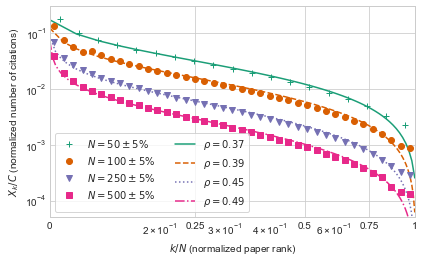

In [13]:
plt.rcParams["figure.figsize"] = (6, 3.75)
xmin = 0.1
xmax = 1

Ps = [0.37, 0.39, 0.45, 0.49]
Ns = [50, 100, 250, 500]
cols = plt.get_cmap("Dark2").colors
lss = ["-", "--", ":", "-.", "--"]
mrk = ["+", "o", "v", "s"]
for ni in range(len(Ns)):
    n=Ns[ni]
    P=Ps[ni]
    X3 = [X[i][X[i]>0] for i in range(len(X)) if   np.ceil(n*0.95)<=len(X[i][X[i]>0])<=np.floor(n*1.05) and authors_subset[i]]
    x_log_bins = np.geomspace(xmin, xmax+1e-9, min(int(np.floor(n*0.4)), 40))
    counts = np.zeros(len(x_log_bins))
    vals   = np.zeros(len(x_log_bins))
    print(len(X3), np.ceil(n*0.95), np.floor(n*1.05))
    for i in range(len(X3)):
        x = X3[i]
        u = np.linspace(xmin, xmax, len(x))
        dg = np.digitize(u, x_log_bins)
        for j in range(len(x)):
            counts[dg[j]]+=1
            vals[dg[j]]+=x[j]/x.sum()
        
    plt.plot((x_log_bins[1:]+x_log_bins[:-1])/2, vals[1:]/counts[1:], color=cols[ni], marker=mrk[ni], ls="None", label=r"$N=%3d \pm 5\%%$"%n)
    
    u = np.arange(1, n+1)
    v = (1.0-P)*(scipy.special.poch(u,-P)/scipy.special.poch(max(u)+1,-P)  -1.0)/max(u)/P 
    plt.plot(np.linspace(xmin, xmax, len(u)), v/v.sum(), color=cols[ni], ls=lss[ni], label=r"$\rho=%.2f$"%P)



plt.xscale("log")
plt.yscale("log")
plt.xlim(xmin, xmax)
plt.ylim(5e-5, 3e-1)
plt.gca().xaxis.get_major_formatter().labelOnlyBase = True
plt.xlabel("$k/N$ (normalized paper rank)")
plt.ylabel("$X_k/C$ (normalized number of citations)")

import itertools
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(flip(handles, 2), flip(labels, 2), ncol=2, loc="lower left", frameon=True, )

plt.gca().xaxis.set_ticks([xmin, 0.25, 0.5, 0.75, xmax])
plt.gca().xaxis.set_ticklabels(["0","0.25","0.5","0.75","1"])
plt.tight_layout()
plt.savefig("figure2.pdf", transparent=True)
plt.show()